TO DO

* https://keras.io/callbacks/#csvlogger csv logger so I dont have to keep copy and paste. Does it work with interrupts?
* Add examples from test set to see how we did
    * Find a really good example to put on the header here, might want to save it via the images notebook
* Train w/o batchnorm because batch_size = 1
     * See https://stackoverflow.com/questions/48320854/tensorflow-and-batch-normalization-with-batch-size-1-outputs-all-zeros 
     * Really bad

# Learn

Here we train a convolutional neural network to predict road networks in aerial images.

In [1]:
import numpy as np
import rasterio
import h5py
import os

from metrics import *

from sklearn.model_selection import train_test_split
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, Add, Lambda, Conv2DTranspose, Cropping2D, UpSampling2D, Concatenate
from keras.models import Model, load_model
from keras import backend as K

sns.set_style('white')
sns.set_context('poster')

/home/carlos/anaconda3/envs/geo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The CNN architecture is based on the [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) which has been used successfully for various image segmentation tasks. The original U-Net architecture is slightly modified to use addition instead of concatenation for the long-skip connections and to incorporate dropout to avoid overfitting. 

In [2]:
## Blocks of CNN architecture

def conv_block(X, n_filters = 32, sz_filters = (3,3)):
    X = Conv2D(n_filters, sz_filters, activation='relu', padding='Same')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    return X

def enc_block(X, n_filters = 64, sz_filters = (3,3)):
    X = conv_block(X, n_filters, sz_filters)
    X = conv_block(X, n_filters, sz_filters)
    down = MaxPooling2D(pool_size=(2, 2))(X)
    down = Dropout(0.2)(down)
    return (down, X)

def deconv_block(X, shortcut, n_filters = 32, sz_filters = (2,2)):
    X = Conv2DTranspose(n_filters, sz_filters, strides=(2,2), activation='relu', padding='Same')(X)
    X = Dropout(0.2)(X)
#     X = Concatenate(axis = 3)([X, shortcut])
    X = Add()([X, shortcut])
    return X

def dec_block(X, shortcut, n_filters = 64, sz_filters = (3,3)):
    X = deconv_block(X, shortcut, n_filters, sz_filters)
    X = conv_block(X, n_filters, sz_filters)
    X = conv_block(X, n_filters, sz_filters)
    return X

In [3]:
K.clear_session()

inputs = Input((640, 640, 3))

enc2, enc1 = enc_block(inputs, n_filters = 64)
enc3, enc2 = enc_block(enc2, n_filters = 128)
bridge, enc3 = enc_block(enc3, n_filters = 256)
bridge = conv_block(bridge, n_filters = 512)
bridge = conv_block(bridge, n_filters = 512)
dec3 = dec_block(bridge, enc3, n_filters = 256)
dec2 = dec_block(dec3, enc2, n_filters = 128)
dec1 = dec_block(dec2, enc1, n_filters = 64)

output = Conv2D(1, (1, 1), activation='sigmoid', padding='Same')(dec1)
output = Cropping2D((64, 64))(output)


model = Model(inputs, output)

print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 640, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 640, 640, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 640, 640, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Select to use the small subset or full data.

In [4]:
# hdf5_path = 'data/naip/hdf5/phoenix_subset.h5'
hdf5_path = 'data/naip/hdf5/phoenix.h5'

## New session

Use this cell to start a new training session that will checkpoint at every epoch.

In [6]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
metrics=[dice_coef, fmeasure, precision, recall, 'binary_crossentropy']
callbacks = [
    EarlyStopping(patience = 3), 
    ModelCheckpoint('models/unet3_epoch{epoch:02d}_loss{val_loss:.4f}.hdf5'),
    CSVLogger('models/unet3_log.csv', append = True)
]
optimizer = Adam()

model.compile(loss = dice_coef_loss,
              optimizer = optimizer,
              metrics = metrics,
              options = run_opts)


with h5py.File(hdf5_path, 'r') as data:
    model.fit(data['X_train'], data['Y_train'], 
              validation_data=(data['X_dev'], data['Y_dev']), 
              batch_size=1, 
              epochs=30, 
              verbose=1,
              shuffle = 'batch',
              callbacks=callbacks)

Train on 12864 samples, validate on 1632 samples
Epoch 1/30
12864/12864 [==============================] - 7540s 586ms/step - loss: -0.2867 - dice_coef: 0.2867 - fmeasure: 0.1341 - precision: 0.1386 - recall: 0.1495 - binary_crossentropy: 0.7252 - val_loss: -0.2600 - val_dice_coef: 0.2600 - val_fmeasure: 1.1558e-06 - val_precision: 2.4267e-05 - val_recall: 5.9202e-07 - val_binary_crossentropy: 0.7050
Epoch 2/30
12864/12864 [==============================] - 7541s 586ms/step - loss: -0.3330 - dice_coef: 0.3330 - fmeasure: 0.2096 - precision: 0.2655 - recall: 0.2075 - binary_crossentropy: 0.7055 - val_loss: -0.2471 - val_dice_coef: 0.2471 - val_fmeasure: 0.0058 - val_precision: 0.0485 - val_recall: 0.0047 - val_binary_crossentropy: 0.7501
Epoch 3/30
12864/12864 [==============================] - 7576s 589ms/step - loss: -0.2645 - dice_coef: 0.2645 - fmeasure: 0.0032 - precision: 0.0064 - recall: 0.0025 - binary_crossentropy: 0.7191 - val_loss: -0.2558 - val_dice_coef: 0.2558 - val_fmeasu

## Continue session

Use these cells (with the correct path in `load_model()` and `initial_epoch` parameter in the `fit()` call) to resume training from a saved checkpoint.

In [5]:
callbacks = [
    EarlyStopping(patience = 3), 
    ModelCheckpoint('models/unet3_epoch{epoch:02d}_loss{val_loss:.4f}.hdf5'),
    CSVLogger('models/unet3_log.csv', append = True)
]

custom_objects = {
    'dice_coef_loss': dice_coef_loss, 
    'dice_coef': dice_coef,
    'fmeasure': fmeasure,
    'precision': precision,
    'recall': recall
}
model = load_model('models/unet3_epoch03_loss-0.2558.hdf5', custom_objects = custom_objects)

with h5py.File(hdf5_path, 'r') as data:
    model.fit(data['X_train'], data['Y_train'], 
              validation_data=(data['X_dev'], data['Y_dev']), 
              batch_size=1, 
              epochs=30, 
              verbose=1,
              shuffle = 'batch',
              callbacks=callbacks,
              initial_epoch = 3)

Train on 12864 samples, validate on 1632 samples
Epoch 4/30
12864/12864 [==============================] - 7505s 583ms/step - loss: -0.2640 - dice_coef: 0.2640 - fmeasure: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_crossentropy: 0.7193 - val_loss: -0.1754 - val_dice_coef: 0.1754 - val_fmeasure: 4.9500e-04 - val_precision: 9.4374e-04 - val_recall: 0.0021 - val_binary_crossentropy: 0.9383
Epoch 5/30
12864/12864 [==============================] - 7509s 584ms/step - loss: -0.2640 - dice_coef: 0.2640 - fmeasure: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_crossentropy: 0.7193 - val_loss: -0.2608 - val_dice_coef: 0.2608 - val_fmeasure: 5.4926e-05 - val_precision: 6.2947e-04 - val_recall: 2.8959e-05 - val_binary_crossentropy: 0.7042
Epoch 6/30
12864/12864 [==============================] - 7490s 582ms/step - loss: -0.2641 - dice_coef: 0.2641 - fmeasure: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_crossentropy: 0.7193 - val_loss: 

KeyboardInterrupt: 

## Evaluation

We'll check the final metrics on the unused test set and visually inspect the results.

In [19]:
custom_objects = {
    'dice_coef_loss': dice_coef_loss, 
    'dice_coef': dice_coef,
    'fmeasure': fmeasure,
    'precision': precision,
    'recall': recall
}
model = load_model('models/unet_9_epoch22_loss-0.5965.hdf5', custom_objects=custom_objects)
hdf5_path = 'data/naip/hdf5/phoenix.h5'

In [7]:
with h5py.File(hdf5_path, 'r') as data:
    test_metrics = model.evaluate(data['X_test'], data['Y_test'], batch_size = 8) 

for pair in zip(model.metrics_names, test_metrics):
    print(pair)

1632/1632 [==============================] - 204s 125ms/step


Although the metrics are helpful for performance tuning, this project is somewhat tolerant of errors. The image processing techniques applied later on will fill in small gaps and mistakes in predictions. Thus, it would be beneficial to visually inspect a few examples to see if the model is at least generally detecting the essentialy road network in an image.

SCRATCH: ndx 4 is good.

In [46]:
with h5py.File(hdf5_path, 'r') as data:
    X = data['.']['X_test'][1000:1100]
    Y = data['.']['Y_test'][1000:1100]
Yhat = model.predict(X, batch_size = 8)

Text(0.5,1,'Estimation')

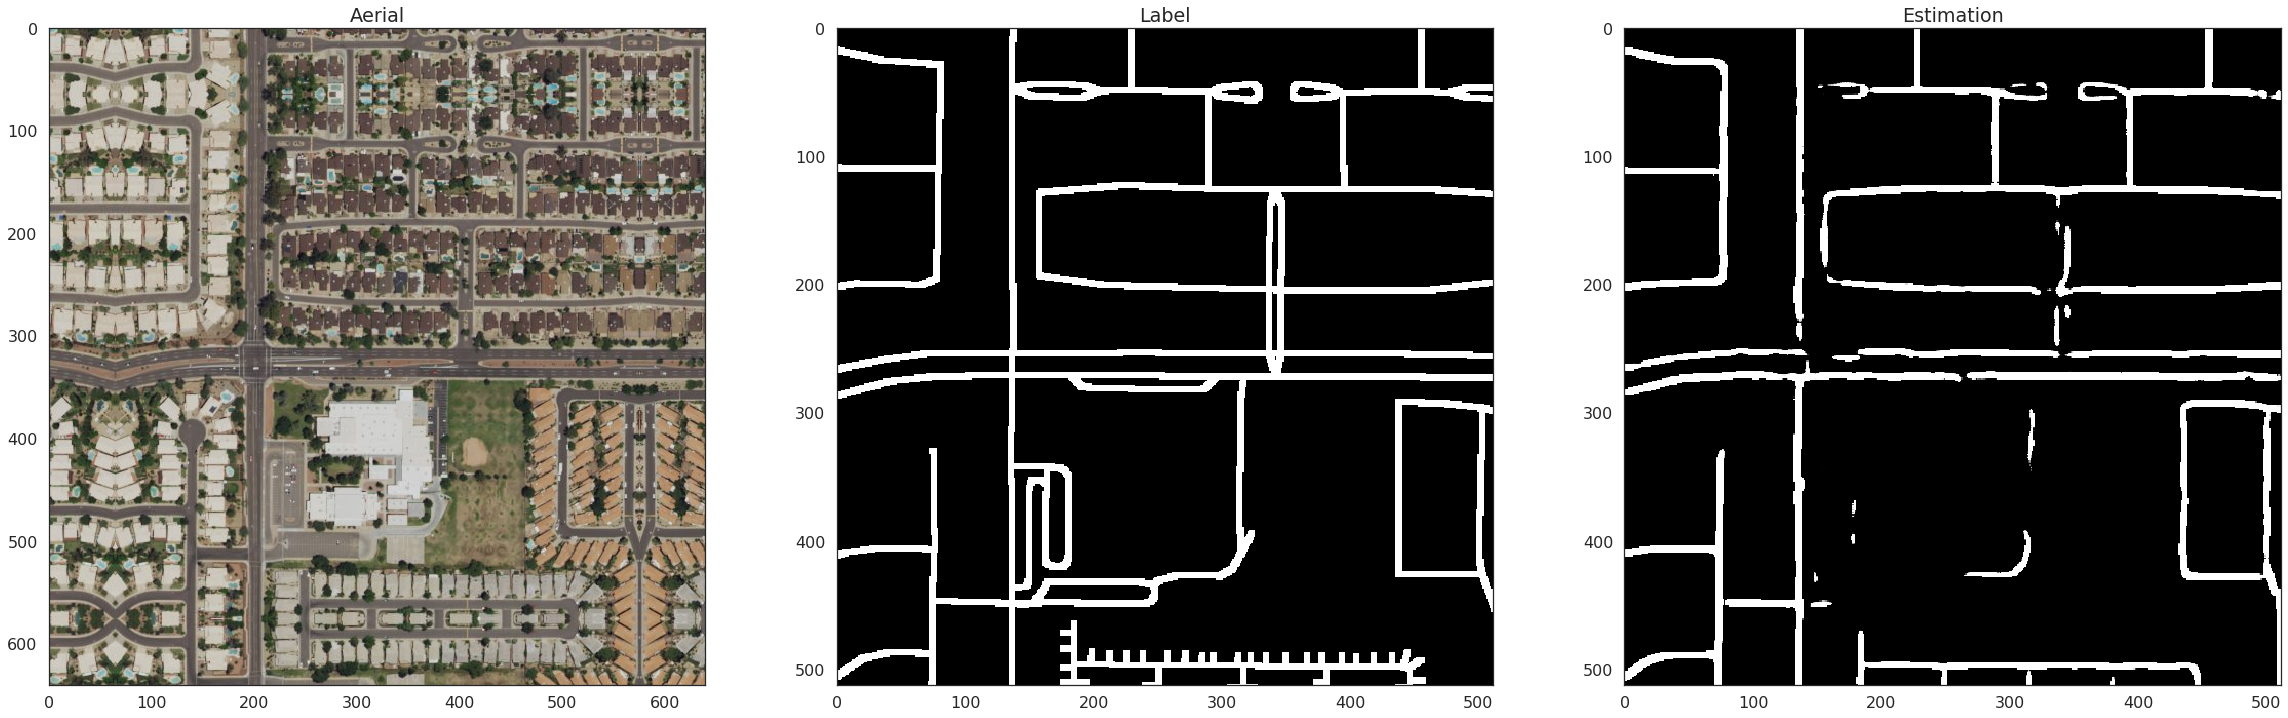

In [55]:
ndx = 4

X_ex = X[ndx]
Y_ex = Y[ndx, :, :, 0]
Yhat_ex = Yhat[ndx, :, :, 0]

fig, axarr = plt.subplots(1, 3, figsize = (40,40))

axarr[0].imshow(X_ex)
axarr[0].set_title('Aerial')
axarr[1].imshow(Y_ex, cmap = 'gray')
axarr[1].set_title('Label')
axarr[2].imshow(Yhat_ex, cmap = 'gray')
axarr[2].set_title('Estimation')

In [56]:
fig.savefig('test.png', bbox_inches='tight')

Now trying Unet w/ BN, concatenation, and dropout=0.5.
Prefix: unet_

Train loss looked good but it did not generalize, but quickly fizzled out.
---
Prefix unet2_
Now trying Unet w/ BN, add, dropout=0.5
Didn't do well

---

Going back to original setup: BN, addition skips, dropout = 0.2
Prefix is unet3_

---


Model saved at `models/unet_1.h5`

Basic unet w/ BN but w/o Dropout. Used a batch size of 2.


```
Train on 1608 samples, validate on 204 samples
Epoch 1/30
1608/1608 [==============================] - 550s 342ms/step - loss: 0.1454 - dice_coef: 0.3039 - fmeasure: 0.3768 - precision: 0.6116 - recall: 0.3080 - val_loss: 0.1341 - val_dice_coef: 0.3064 - val_fmeasure: 0.3501 - val_precision: 0.7012 - val_recall: 0.2457
Epoch 2/30
1608/1608 [==============================] - 485s 302ms/step - loss: 0.1170 - dice_coef: 0.3919 - fmeasure: 0.5082 - precision: 0.6714 - recall: 0.4341 - val_loss: 0.1338 - val_dice_coef: 0.3798 - val_fmeasure: 0.4156 - val_precision: 0.7454 - val_recall: 0.3054
Epoch 3/30
1608/1608 [==============================] - 485s 301ms/step - loss: 0.1093 - dice_coef: 0.4217 - fmeasure: 0.5375 - precision: 0.6824 - recall: 0.4687 - val_loss: 0.1438 - val_dice_coef: 0.3355 - val_fmeasure: 0.3483 - val_precision: 0.7436 - val_recall: 0.2442
Epoch 4/30
1608/1608 [==============================] - 490s 305ms/step - loss: 0.1053 - dice_coef: 0.4394 - fmeasure: 0.5532 - precision: 0.6903 - recall: 0.4854 - val_loss: 0.3106 - val_dice_coef: 0.0255 - val_fmeasure: 0.0064 - val_precision: 0.3549 - val_recall: 0.0033
```
Looks like train->validation is a problem, so I will try dropout for regularization

---
Model saved at `models/unet_2.h5`

UNET w/ BN and dropout ONLY after max-pooling and up-sampling. Had to train on batch-size of 1 (2 gave OOM)
```
Train on 1608 samples, validate on 204 samples
Epoch 1/30
1608/1608 [==============================] - 593s 369ms/step - loss: 0.1391 - dice_coef: 0.2890 - fmeasure: 0.3589 - precision: 0.5731 - recall: 0.2973 - val_loss: 0.2345 - val_dice_coef: 0.1106 - val_fmeasure: 0.0462 - val_precision: 0.5969 - val_recall: 0.0266
Epoch 2/30
1608/1608 [==============================] - 589s 366ms/step - loss: 0.1187 - dice_coef: 0.3644 - fmeasure: 0.4670 - precision: 0.6221 - recall: 0.4106 - val_loss: 0.1312 - val_dice_coef: 0.3250 - val_fmeasure: 0.3419 - val_precision: 0.6911 - val_recall: 0.2526
Epoch 3/30
1608/1608 [==============================] - 589s 366ms/step - loss: 0.1114 - dice_coef: 0.3901 - fmeasure: 0.4942 - precision: 0.6314 - recall: 0.4413 - val_loss: 0.1238 - val_dice_coef: 0.3535 - val_fmeasure: 0.4111 - val_precision: 0.6521 - val_recall: 0.3226
Epoch 4/30
1608/1608 [==============================] - 589s 366ms/step - loss: 0.1069 - dice_coef: 0.4066 - fmeasure: 0.5128 - precision: 0.6350 - recall: 0.4632 - val_loss: 0.1087 - val_dice_coef: 0.4187 - val_fmeasure: 0.4962 - val_precision: 0.6362 - val_recall: 0.4332
Epoch 5/30
1608/1608 [==============================] - 588s 366ms/step - loss: 0.1021 - dice_coef: 0.4254 - fmeasure: 0.5302 - precision: 0.6487 - recall: 0.4825 - val_loss: 0.1115 - val_dice_coef: 0.4227 - val_fmeasure: 0.4795 - val_precision: 0.6572 - val_recall: 0.4012
Epoch 6/30
1608/1608 [==============================] - 587s 365ms/step - loss: 0.0998 - dice_coef: 0.4335 - fmeasure: 0.5368 - precision: 0.6473 - recall: 0.4908 - val_loss: 0.1163 - val_dice_coef: 0.3739 - val_fmeasure: 0.4277 - val_precision: 0.6761 - val_recall: 0.3366
```
This was better at generalizing from train to dev. I'll try again with more dropouts.

---
Model saved at `models/unet_3.h5`

UNET w/ BN and more dropout (after conv, max-pool, and up-sampling).

This iteration had the best scores across most metrics including (val-)loss and (val-)dice coefficient, so it's the contender for best architecture. Next iterations will include LR decay.
```
Train on 1608 samples, validate on 204 samples
Epoch 1/30
1608/1608 [==============================] - 768s 478ms/step - loss: 0.1415 - dice_coef: 0.2954 - fmeasure: 0.3635 - precision: 0.5658 - recall: 0.3055 - val_loss: 0.1580 - val_dice_coef: 0.3169 - val_fmeasure: 0.4792 - val_precision: 0.4704 - val_recall: 0.5198
Epoch 2/30
1608/1608 [==============================] - 760s 473ms/step - loss: 0.1199 - dice_coef: 0.3588 - fmeasure: 0.4526 - precision: 0.6126 - recall: 0.3959 - val_loss: 0.2385 - val_dice_coef: 0.2626 - val_fmeasure: 0.4430 - val_precision: 0.3527 - val_recall: 0.6368
Epoch 3/30
1608/1608 [==============================] - 758s 471ms/step - loss: 0.1113 - dice_coef: 0.3910 - fmeasure: 0.4887 - precision: 0.6267 - recall: 0.4361 - val_loss: 0.1219 - val_dice_coef: 0.3969 - val_fmeasure: 0.4955 - val_precision: 0.5613 - val_recall: 0.4754
Epoch 4/30
1608/1608 [==============================] - 757s 471ms/step - loss: 0.1063 - dice_coef: 0.4097 - fmeasure: 0.5078 - precision: 0.6383 - recall: 0.4555 - val_loss: 0.1131 - val_dice_coef: 0.3930 - val_fmeasure: 0.4698 - val_precision: 0.6320 - val_recall: 0.4047
Epoch 5/30
1608/1608 [==============================] - 756s 470ms/step - loss: 0.1031 - dice_coef: 0.4226 - fmeasure: 0.5197 - precision: 0.6428 - recall: 0.4697 - val_loss: 0.1433 - val_dice_coef: 0.3229 - val_fmeasure: 0.4521 - val_precision: 0.6072 - val_recall: 0.3893
Epoch 6/30
1608/1608 [==============================] - 756s 470ms/step - loss: 0.1005 - dice_coef: 0.4320 - fmeasure: 0.5290 - precision: 0.6498 - recall: 0.4786 - val_loss: 0.1102 - val_dice_coef: 0.4161 - val_fmeasure: 0.4989 - val_precision: 0.6380 - val_recall: 0.4366
Epoch 7/30
1608/1608 [==============================] - 756s 470ms/step - loss: 0.0979 - dice_coef: 0.4427 - fmeasure: 0.5412 - precision: 0.6576 - recall: 0.4898 - val_loss: 0.1087 - val_dice_coef: 0.4303 - val_fmeasure: 0.5048 - val_precision: 0.6537 - val_recall: 0.4383
Epoch 8/30
1608/1608 [==============================] - 755s 470ms/step - loss: 0.0963 - dice_coef: 0.4482 - fmeasure: 0.5474 - precision: 0.6631 - recall: 0.4969 - val_loss: 0.1152 - val_dice_coef: 0.4586 - val_fmeasure: 0.5329 - val_precision: 0.6042 - val_recall: 0.5156
Epoch 9/30
1608/1608 [==============================] - 755s 470ms/step - loss: 0.0941 - dice_coef: 0.4570 - fmeasure: 0.5557 - precision: 0.6685 - recall: 0.5069 - val_loss: 0.1049 - val_dice_coef: 0.4334 - val_fmeasure: 0.5109 - val_precision: 0.6503 - val_recall: 0.4456
Epoch 10/30
1608/1608 [==============================] - 755s 470ms/step - loss: 0.0929 - dice_coef: 0.4637 - fmeasure: 0.5617 - precision: 0.6743 - recall: 0.5121 - val_loss: 0.1090 - val_dice_coef: 0.4267 - val_fmeasure: 0.5213 - val_precision: 0.6468 - val_recall: 0.4615
Epoch 11/30
1608/1608 [==============================] - 755s 470ms/step - loss: 0.0911 - dice_coef: 0.4690 - fmeasure: 0.5683 - precision: 0.6771 - recall: 0.5184 - val_loss: 0.1126 - val_dice_coef: 0.4330 - val_fmeasure: 0.5079 - val_precision: 0.6268 - val_recall: 0.4559
```

---
`unet_5.h5`

Now trying same arch above but with Adam decay param set to 0.05. Did not do so hot.

```
WARNING:tensorflow:Variable *= will be deprecated. Use variable.assign_mul if you want assignment to the variable value or 'x = x * y' if you want a new python Tensor object.
Train on 1608 samples, validate on 204 samples
Epoch 1/30
1608/1608 [==============================] - 770s 479ms/step - loss: 0.1451 - dice_coef: 0.2871 - fmeasure: 0.3559 - precision: 0.5484 - recall: 0.2922 - val_loss: 0.1454 - val_dice_coef: 0.2973 - val_fmeasure: 0.3134 - val_precision: 0.6400 - val_recall: 0.2320
Epoch 2/30
1608/1608 [==============================] - 762s 474ms/step - loss: 0.1277 - dice_coef: 0.3352 - fmeasure: 0.4272 - precision: 0.5882 - recall: 0.3628 - val_loss: 0.1418 - val_dice_coef: 0.3161 - val_fmeasure: 0.3594 - val_precision: 0.6369 - val_recall: 0.2824
Epoch 3/30
1608/1608 [==============================] - 761s 473ms/step - loss: 0.1244 - dice_coef: 0.3479 - fmeasure: 0.4423 - precision: 0.5958 - recall: 0.3788 - val_loss: 0.1418 - val_dice_coef: 0.3164 - val_fmeasure: 0.3482 - val_precision: 0.6502 - val_recall: 0.2657
Epoch 4/30
1608/1608 [==============================] - 759s 472ms/step - loss: 0.1228 - dice_coef: 0.3533 - fmeasure: 0.4484 - precision: 0.5995 - recall: 0.3852 - val_loss: 0.1477 - val_dice_coef: 0.3084 - val_fmeasure: 0.3311 - val_precision: 0.6564 - val_recall: 0.2488
```

---

`unet_6.h5`

Same setup as `unet_3.h5` (lots of dropout, no learning rate decay) but on the full PHX training set. Good loss but generalized very poorly.

```
Train on 12864 samples, validate on 1632 samples
Epoch 1/30
12864/12864 [==============================] - 9614s 747ms/step - loss: 0.0753 - dice_coef: 0.2375 - fmeasure: 0.2779 - precision: 0.4103 - recall: 0.2438 - val_loss: 0.8393 - val_dice_coef: 0.1785 - val_fmeasure: 0.1821 - val_precision: 0.2747 - val_recall: 0.1803
Epoch 2/30
12864/12864 [==============================] - 9617s 748ms/step - loss: 0.0635 - dice_coef: 0.2817 - fmeasure: 0.3300 - precision: 0.4514 - recall: 0.2940 - val_loss: 0.0850 - val_dice_coef: 0.2280 - val_fmeasure: 0.2568 - val_precision: 0.3829 - val_recall: 0.2140
Epoch 3/30
12864/12864 [==============================] - 9539s 742ms/step - loss: 0.0603 - dice_coef: 0.2962 - fmeasure: 0.3476 - precision: 0.4613 - recall: 0.3122 - val_loss: 0.4742 - val_dice_coef: 0.2460 - val_fmeasure: 0.3035 - val_precision: 0.3410 - val_recall: 0.3120
Epoch 4/30
12864/12864 [==============================] - 9532s 741ms/step - loss: 0.0584 - dice_coef: 0.3046 - fmeasure: 0.3566 - precision: 0.4649 - recall: 0.3220 - val_loss: 0.1524 - val_dice_coef: 0.2795 - val_fmeasure: 0.3214 - val_precision: 0.4164 - val_recall: 0.2874

```

---

`unet_7.h5`

Same as `unet_3.h5` but with dice coeff loss. Ran on small train set. Precision and recall is promising. Did not generalize well in some epochs.

```
Train on 1608 samples, validate on 204 samples
Epoch 1/30
1608/1608 [==============================] - 785s 488ms/step - loss: -0.4619 - dice_coef: 0.4619 - fmeasure: 0.4621 - precision: 0.4543 - recall: 0.5107 - binary_crossentropy: 0.6711 - val_loss: -0.2471 - val_dice_coef: 0.2471 - val_fmeasure: 0.2367 - val_precision: 0.1901 - val_recall: 0.3825 - val_binary_crossentropy: 1.8970
Epoch 2/30
1608/1608 [==============================] - 757s 471ms/step - loss: -0.4695 - dice_coef: 0.4695 - fmeasure: 0.4651 - precision: 0.4653 - recall: 0.5105 - binary_crossentropy: 0.7919 - val_loss: -0.5277 - val_dice_coef: 0.5277 - val_fmeasure: 0.4492 - val_precision: 0.5399 - val_recall: 0.4217 - val_binary_crossentropy: 0.7295
Epoch 3/30
1608/1608 [==============================] - 753s 468ms/step - loss: -0.5396 - dice_coef: 0.5396 - fmeasure: 0.5130 - precision: 0.5115 - recall: 0.5517 - binary_crossentropy: 0.7319 - val_loss: -0.5426 - val_dice_coef: 0.5426 - val_fmeasure: 0.4836 - val_precision: 0.4425 - val_recall: 0.5788 - val_binary_crossentropy: 0.9169
Epoch 4/30
1608/1608 [==============================] - 752s 468ms/step - loss: -0.4852 - dice_coef: 0.4852 - fmeasure: 0.4763 - precision: 0.4908 - recall: 0.5048 - binary_crossentropy: 0.7782 - val_loss: -0.4271 - val_dice_coef: 0.4271 - val_fmeasure: 0.3781 - val_precision: 0.3330 - val_recall: 0.5357 - val_binary_crossentropy: 1.8424
Epoch 5/30
1608/1608 [==============================] - 752s 467ms/step - loss: -0.5112 - dice_coef: 0.5112 - fmeasure: 0.5008 - precision: 0.5027 - recall: 0.5366 - binary_crossentropy: 0.7491 - val_loss: -0.3066 - val_dice_coef: 0.3066 - val_fmeasure: 0.2378 - val_precision: 0.3831 - val_recall: 0.2198 - val_binary_crossentropy: 1.4166
```

---

---

`unet_8.h5`

Same as `unet_7.h5` but ran on full train set. Dice coefficient was good, precision/recall not so much. Should compare how segmentation results look with unet_5

```
Train on 12864 samples, validate on 1632 samples
Epoch 1/30
12864/12864 [==============================] - 9580s 745ms/step - loss: -0.2965 - dice_coef: 0.2965 - fmeasure: 0.0802 - precision: 0.1137 - recall: 0.0791 - binary_crossentropy: 0.5156 - val_loss: -0.2649 - val_dice_coef: 0.2649 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_crossentropy: 0.5006
Epoch 2/30
12864/12864 [==============================] - 9514s 740ms/step - loss: -0.2795 - dice_coef: 0.2795 - fmeasure: 0.1245 - precision: 0.1450 - recall: 0.1327 - binary_crossentropy: 0.5637 - val_loss: -0.2988 - val_dice_coef: 0.2988 - val_fmeasure: 0.0982 - val_precision: 0.1556 - val_recall: 0.0938 - val_binary_crossentropy: 0.6168
Epoch 3/30
12864/12864 [==============================] - 9569s 744ms/step - loss: -0.3451 - dice_coef: 0.3451 - fmeasure: 0.1482 - precision: 0.1995 - recall: 0.1430 - binary_crossentropy: 0.5221 - val_loss: -0.4744 - val_dice_coef: 0.4744 - val_fmeasure: 0.2794 - val_precision: 0.2755 - val_recall: 0.3215 - val_binary_crossentropy: 0.5205
Epoch 4/30
12864/12864 [==============================] - 9502s 739ms/step - loss: -0.4770 - dice_coef: 0.4770 - fmeasure: 0.2716 - precision: 0.3037 - recall: 0.2806 - binary_crossentropy: 0.4712 - val_loss: -0.5046 - val_dice_coef: 0.5046 - val_fmeasure: 0.3018 - val_precision: 0.2948 - val_recall: 0.3464 - val_binary_crossentropy: 0.4944
Epoch 5/30
12864/12864 [==============================] - 9525s 740ms/step - loss: -0.4700 - dice_coef: 0.4700 - fmeasure: 0.2567 - precision: 0.2969 - recall: 0.2622 - binary_crossentropy: 0.4643 - val_loss: -0.5456 - val_dice_coef: 0.5456 - val_fmeasure: 0.3159 - val_precision: 0.3271 - val_recall: 0.3386 - val_binary_crossentropy: 0.4341
Epoch 6/30
12864/12864 [==============================] - 9446s 734ms/step - loss: -0.5068 - dice_coef: 0.5068 - fmeasure: 0.2894 - precision: 0.3204 - recall: 0.2994 - binary_crossentropy: 0.4491 - val_loss: -0.3055 - val_dice_coef: 0.3055 - val_fmeasure: 0.2164 - val_precision: 0.2546 - val_recall: 0.2168 - val_binary_crossentropy: 0.5947
Epoch 7/30
12864/12864 [==============================] - 9416s 732ms/step - loss: -0.4725 - dice_coef: 0.4725 - fmeasure: 0.2443 - precision: 0.2835 - recall: 0.2496 - binary_crossentropy: 0.4573 - val_loss: -0.5658 - val_dice_coef: 0.5658 - val_fmeasure: 0.3190 - val_precision: 0.3438 - val_recall: 0.3286 - val_binary_crossentropy: 0.4084
Epoch 8/30
12864/12864 [==============================] - 9479s 737ms/step - loss: -0.5319 - dice_coef: 0.5319 - fmeasure: 0.3071 - precision: 0.3328 - recall: 0.3189 - binary_crossentropy: 0.4348 - val_loss: -0.4363 - val_dice_coef: 0.4363 - val_fmeasure: 0.1982 - val_precision: 0.3111 - val_recall: 0.1627 - val_binary_crossentropy: 0.4480
Epoch 9/30
12864/12864 [==============================] - 9543s 742ms/step - loss: -0.5305 - dice_coef: 0.5305 - fmeasure: 0.3100 - precision: 0.3350 - recall: 0.3220 - binary_crossentropy: 0.4294 - val_loss: -0.5288 - val_dice_coef: 0.5288 - val_fmeasure: 0.3171 - val_precision: 0.3547 - val_recall: 0.3195 - val_binary_crossentropy: 0.4018
```

---

`unet_9_{}.hdf5`

Same as above but with checkpoints at each epoch. Also running on updated training set with two iter of dilation done.

```
Train on 12864 samples, validate on 1632 samples
Epoch 1/30
12864/12864 [==============================] - 7630s 593ms/step - loss: -0.3267 - dice_coef: 0.3267 - fmeasure: 0.2795 - precision: 0.2814 - recall: 0.3138 - binary_crossentropy: 0.7324 - val_loss: -0.1839 - val_dice_coef: 0.1839 - val_fmeasure: 0.0014 - val_precision: 0.0053 - val_recall: 0.0024 - val_binary_crossentropy: 0.8627
Epoch 2/30
12864/12864 [==============================] - 7630s 593ms/step - loss: -0.2926 - dice_coef: 0.2926 - fmeasure: 0.1100 - precision: 0.1164 - recall: 0.1167 - binary_crossentropy: 0.7062 - val_loss: -0.0301 - val_dice_coef: 0.0301 - val_fmeasure: 0.0137 - val_precision: 0.0342 - val_recall: 0.0467 - val_binary_crossentropy: 2.5306
Epoch 3/30
12864/12864 [==============================] - 7657s 595ms/step - loss: -0.2790 - dice_coef: 0.2790 - fmeasure: 0.0581 - precision: 0.0611 - recall: 0.0621 - binary_crossentropy: 0.7086 - val_loss: -0.2649 - val_dice_coef: 0.2649 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_crossentropy: 0.7036
Epoch 4/30
12864/12864 [==============================] - 7624s 593ms/step - loss: -0.2640 - dice_coef: 0.2640 - fmeasure: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_crossentropy: 0.7193 - val_loss: -0.2649 - val_dice_coef: 0.2649 - val_fmeasure: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_crossentropy: 0.7036
Epoch 5/30
12864/12864 [==============================] - 7631s 593ms/step - loss: -0.2911 - dice_coef: 0.2911 - fmeasure: 0.0688 - precision: 0.0715 - recall: 0.0739 - binary_crossentropy: 0.7051 - val_loss: -0.4746 - val_dice_coef: 0.4746 - val_fmeasure: 0.2928 - val_precision: 0.4043 - val_recall: 0.2569 - val_binary_crossentropy: 0.5165
Epoch 6/30
12864/12864 [==============================] - 7596s 590ms/step - loss: -0.4591 - dice_coef: 0.4591 - fmeasure: 0.2343 - precision: 0.2625 - recall: 0.2406 - binary_crossentropy: 0.5946 - val_loss: -0.5365 - val_dice_coef: 0.5365 - val_fmeasure: 0.3614 - val_precision: 0.3737 - val_recall: 0.3841 - val_binary_crossentropy: 0.5244
Epoch 7/30
  101/12864 [..............................] - ETA: 2:17:28 - loss: -0.5800 - dice_coef: 0.5800 - fmeasure: 0.4012 - precision: 0.4097 - recall: 0.4113 - binary_crossentropy: 0.4852
Train on 12864 samples, validate on 1632 samples
Epoch 7/30
12864/12864 [==============================] - 7434s 578ms/step - loss: -0.5030 - dice_coef: 0.5030 - fmeasure: 0.2705 - precision: 0.2933 - recall: 0.2792 - binary_crossentropy: 0.5723 - val_loss: -0.2667 - val_dice_coef: 0.2667 - val_fmeasure: 0.0018 - val_precision: 0.0422 - val_recall: 9.6676e-04 - val_binary_crossentropy: 0.7026
Epoch 8/30
12864/12864 [==============================] - 7478s 581ms/step - loss: -0.5135 - dice_coef: 0.5135 - fmeasure: 0.2863 - precision: 0.3163 - recall: 0.2959 - binary_crossentropy: 0.5685 - val_loss: -0.5255 - val_dice_coef: 0.5255 - val_fmeasure: 0.3617 - val_precision: 0.3982 - val_recall: 0.3620 - val_binary_crossentropy: 0.4753
Epoch 9/30
12864/12864 [==============================] - 7458s 580ms/step - loss: -0.5708 - dice_coef: 0.5708 - fmeasure: 0.3437 - precision: 0.3727 - recall: 0.3535 - binary_crossentropy: 0.5320 - val_loss: -0.3258 - val_dice_coef: 0.3258 - val_fmeasure: 0.0634 - val_precision: 0.3688 - val_recall: 0.0390 - val_binary_crossentropy: 0.6632
Epoch 10/30
12864/12864 [==============================] - 7465s 580ms/step - loss: -0.5714 - dice_coef: 0.5714 - fmeasure: 0.3388 - precision: 0.3682 - recall: 0.3484 - binary_crossentropy: 0.5378 - val_loss: -0.5596 - val_dice_coef: 0.5596 - val_fmeasure: 0.3635 - val_precision: 0.3971 - val_recall: 0.3664 - val_binary_crossentropy: 0.4928
Epoch 11/30
12864/12864 [==============================] - 7388s 574ms/step - loss: -0.5925 - dice_coef: 0.5925 - fmeasure: 0.3438 - precision: 0.3727 - recall: 0.3532 - binary_crossentropy: 0.5203 - val_loss: -0.4162 - val_dice_coef: 0.4162 - val_fmeasure: 0.1610 - val_precision: 0.4009 - val_recall: 0.1126 - val_binary_crossentropy: 0.5588
Train on 12864 samples, validate on 1632 samples
Epoch 12/30
12864/12864 [==============================] - 7493s 582ms/step - loss: -0.5913 - dice_coef: 0.5913 - fmeasure: 0.3569 - precision: 0.3819 - recall: 0.3684 - binary_crossentropy: 0.5176 - val_loss: -0.4751 - val_dice_coef: 0.4751 - val_fmeasure: 0.3046 - val_precision: 0.4099 - val_recall: 0.2677 - val_binary_crossentropy: 0.4696
Epoch 13/30
12864/12864 [==============================] - 7497s 583ms/step - loss: -0.5919 - dice_coef: 0.5919 - fmeasure: 0.3462 - precision: 0.3741 - recall: 0.3556 - binary_crossentropy: 0.5183 - val_loss: -0.4853 - val_dice_coef: 0.4853 - val_fmeasure: 0.3331 - val_precision: 0.3805 - val_recall: 0.3313 - val_binary_crossentropy: 0.4624
Epoch 14/30
12864/12864 [==============================] - 7458s 580ms/step - loss: -0.5207 - dice_coef: 0.5207 - fmeasure: 0.2688 - precision: 0.2872 - recall: 0.2758 - binary_crossentropy: 0.5607 - val_loss: -0.5835 - val_dice_coef: 0.5835 - val_fmeasure: 0.3632 - val_precision: 0.3888 - val_recall: 0.3750 - val_binary_crossentropy: 0.4970
Epoch 15/30
12864/12864 [==============================] - 7489s 582ms/step - loss: -0.6131 - dice_coef: 0.6131 - fmeasure: 0.3725 - precision: 0.3967 - recall: 0.3824 - binary_crossentropy: 0.4943 - val_loss: -0.5703 - val_dice_coef: 0.5703 - val_fmeasure: 0.3373 - val_precision: 0.4063 - val_recall: 0.3144 - val_binary_crossentropy: 0.4659
Train on 12864 samples, validate on 1632 samples
Epoch 16/30
12864/12864 [==============================] - 7449s 579ms/step - loss: -0.5671 - dice_coef: 0.5671 - fmeasure: 0.3474 - precision: 0.3718 - recall: 0.3599 - binary_crossentropy: 0.5379 - val_loss: -0.4593 - val_dice_coef: 0.4593 - val_fmeasure: 0.3468 - val_precision: 0.3897 - val_recall: 0.3413 - val_binary_crossentropy: 0.4815
Epoch 17/30
12864/12864 [==============================] - 7479s 581ms/step - loss: -0.6150 - dice_coef: 0.6150 - fmeasure: 0.3681 - precision: 0.3893 - recall: 0.3805 - binary_crossentropy: 0.5050 - val_loss: -0.4984 - val_dice_coef: 0.4984 - val_fmeasure: 0.3150 - val_precision: 0.4052 - val_recall: 0.2864 - val_binary_crossentropy: 0.4786
Epoch 18/30
12864/12864 [==============================] - 7477s 581ms/step - loss: -0.6137 - dice_coef: 0.6137 - fmeasure: 0.3649 - precision: 0.3844 - recall: 0.3772 - binary_crossentropy: 0.5053 - val_loss: -0.5883 - val_dice_coef: 0.5883 - val_fmeasure: 0.3563 - val_precision: 0.3947 - val_recall: 0.3584 - val_binary_crossentropy: 0.4789
Epoch 19/30
12864/12864 [==============================] - 7498s 583ms/step - loss: -0.5708 - dice_coef: 0.5708 - fmeasure: 0.3277 - precision: 0.3500 - recall: 0.3396 - binary_crossentropy: 0.5257 - val_loss: -0.5892 - val_dice_coef: 0.5892 - val_fmeasure: 0.3808 - val_precision: 0.4044 - val_recall: 0.3950 - val_binary_crossentropy: 0.4834
Epoch 20/30
12864/12864 [==============================] - 7405s 576ms/step - loss: -0.6179 - dice_coef: 0.6179 - fmeasure: 0.3811 - precision: 0.3976 - recall: 0.3965 - binary_crossentropy: 0.4931 - val_loss: -0.5932 - val_dice_coef: 0.5932 - val_fmeasure: 0.3763 - val_precision: 0.4363 - val_recall: 0.3626 - val_binary_crossentropy: 0.4561
Epoch 21/30
12864/12864 [==============================] - 7397s 575ms/step - loss: -0.6223 - dice_coef: 0.6223 - fmeasure: 0.3777 - precision: 0.3969 - recall: 0.3910 - binary_crossentropy: 0.4872 - val_loss: -0.5764 - val_dice_coef: 0.5764 - val_fmeasure: 0.3299 - val_precision: 0.4167 - val_recall: 0.3016 - val_binary_crossentropy: 0.4622
Epoch 22/30
12864/12864 [==============================] - 7414s 576ms/step - loss: -0.6292 - dice_coef: 0.6292 - fmeasure: 0.3836 - precision: 0.3968 - recall: 0.3986 - binary_crossentropy: 0.4848 - val_loss: -0.5965 - val_dice_coef: 0.5965 - val_fmeasure: 0.3665 - val_precision: 0.4489 - val_recall: 0.3422 - val_binary_crossentropy: 0.4338
Epoch 23/30
12864/12864 [==============================] - 7459s 580ms/step - loss: -0.6329 - dice_coef: 0.6329 - fmeasure: 0.3856 - precision: 0.3971 - recall: 0.4011 - binary_crossentropy: 0.4845 - val_loss: -0.5877 - val_dice_coef: 0.5877 - val_fmeasure: 0.3688 - val_precision: 0.4329 - val_recall: 0.3539 - val_binary_crossentropy: 0.4531
```

---

U-net 10

As above but with no bartch norm